In [2]:
import os
import numpy as np
import gzip
import collections
import sys
sys.path.append('/cbscratch/franco/tejaas')
from iotools import readgtf
from utils import cismasking

sys.path.append('../../')
import operator
import json
from utils import utils
json_file = "../../gtex_v8_metadata.json"
tissue_file = "../../plots/tissue_table.txt"
tshorts, tfulls_plain = utils.read_tissues(tissue_file, plain=True)
_, tfulls = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors  = dict()
tissue_names   = dict()
tissue_samples = dict()
for tshort, tfull in zip(tshorts, tfulls_plain):
    tissue_names[tshort] = tfull
for tshort, tfull in zip(tshorts, tfulls):
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

brain_tissues = ['bam','ban','bca','bceh','bce','bco','bfr','bhi','bhy','bnu','bpu','bsp','bsu']   
optim_tissues = ['haa', 'pan', 'spl', 'wb']



In [3]:
base_dir = "/cbscratch/franco/datasets"
gtffile = os.path.join(base_dir, "GENCODE/gencode.v26.annotation.gtf.gz")
genemapfile  = os.path.join(base_dir, "crossmappability/hg38_gene_mappability.txt.gz")
crossmapfile = os.path.join(base_dir, "crossmappability/hg38_cross_mappability_strength.txt.gz")

In [4]:
SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

    
def Snp2info(snps_list):
    snpinfo = list()
    for snpid in snps_list:
        arr = snpid.split("_")
        chrom = int(arr[0][3:])
        pos = int(arr[1])
        this_snp = SnpInfo(chrom      = chrom,
                           bp_pos     = pos,
                           varid      = snpid,
                           ref_allele = "X",
                           alt_allele = "Y",
                           maf        = None)
        snpinfo.append(this_snp)
    return snpinfo
    
def extend_cismask(genes, cismaskcomp, cross_gene_dict):
    # cross_gene_dict = read_crossmap(crossmapfile)
    genes_ix_dict = dict(zip([x.ensembl_id for x in genes], np.arange(len(genes))))
    crossmap_cismaskcomp = list()
    for cismask in cismaskcomp:
        gene_list = list()  # list of crossmapped genes for the cismask
        for gene in [genes[i] for i in cismask.rmv_id]:
            gene_list += cross_gene_dict[gene.ensembl_id]
        uniq_gene_list = list(set(gene_list))
        ugene_dict = collections.defaultdict(lambda: False) # significant speed-up by making a dict
        for g in uniq_gene_list:
            ugene_dict[g] = True
        cm_gene2rmv_ix = [genes_ix_dict[x.ensembl_id] for x in genes if ugene_dict[x.ensembl_id]]
        if len(cm_gene2rmv_ix) > 0:
            new_mask_genes = sorted(list(set(list(cismask.rmv_id) + cm_gene2rmv_ix)))
            new_cismask = cismask._replace(rmv_id = np.array(new_mask_genes))
            crossmap_cismaskcomp.append(new_cismask)
        else:
            crossmap_cismaskcomp.append(cismask)
    return crossmap_cismaskcomp

def read_tissue_genes(gx_file, geneinfo_dict):
    genes = list()
    with open(gx_file) as inst:
        next(inst)
        for line in inst:
            ensembl_id = line.split()[0]
            genes.append(geneinfo_dict[ensembl_id])
    return genes

def read_crossmap(crossmapfile):
    gene_pairs = collections.defaultdict(list)
    with gzip.open(crossmapfile, 'r') as instream:
        for line in instream:
            arr = line.rstrip().split()
            gene_pairs[arr[0].decode('utf-8')].append(arr[1].decode('utf-8'))
    return gene_pairs

cross_gene_dict = read_crossmap(crossmapfile) 

In [5]:
geneinfo = readgtf.gencode(gtffile, trim=False)

In [17]:
import mpmath
mpmath.mp.dps = 50
def pvalue(x): return float(mpmath.log10(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2)))))

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'maf']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()
    
def tejaas(filepath):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            chrom = int(arr[1])
            pos   = int(arr[2])
            maf   = float(arr[3])
            q     = float(arr[4])
            mu    = float(arr[5])
            sigma = float(arr[6])
            p     = float(arr[7])
            if sigma == 0:
                print("eh?")
                continue
            logp  = np.log10(p) if p != 0 else pvalue( (q - mu) / sigma)
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, maf=maf))
    return res

target_file    = "trans_eqtls.txt.ld_prune"

## SHAPEIT 2 data
path_sb01    = "/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma01_knn30_cut5e-8/"
path_sb0006  = "/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma0006_knn30_cut5e-8/"
path_raw     = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2/raw/summary_5e-08/"


teqtls        = os.path.join(path_sb01, "{:s}/trans_eqtls_ldpruned.txt") 
teqtls_cm     = os.path.join(path_raw, "{:s}/tejaas", "permnull_sb0.1_knn30_crossmap", target_file)
alt_teqtls        = os.path.join(path_sb0006, "{:s}/trans_eqtls_ldpruned.txt") 
alt_teqtls_cm     = os.path.join(path_raw, "{:s}/tejaas", "permnull_sb0.006_knn30_crossmap", target_file)

teqtl_dict = collections.defaultdict(dict)
for ts in tshorts:
    if ts not in brain_tissues:
        if ts in optim_tissues:
            teqtl_dict["sb"][ts] = tejaas(alt_teqtls.format(ts))
            teqtl_dict["cm"][ts] = tejaas(alt_teqtls_cm.format(ts))
        else:
            teqtl_dict["sb"][ts] = tejaas(teqtls.format(ts))
            teqtl_dict["cm"][ts] = tejaas(teqtls_cm.format(ts))


# Set of total trans-eQTLs discovered across tissues

In [66]:
unique_set = collections.defaultdict(set)
unique_bi  = set()
unique_fo  = set()
all_teqtl    = list()
all_teqtl_cm = list()
all_teqtl01    = list()
all_teqtl01_cm = list()
all_teqtl0006  = list()
all_teqtl0006_cm = list()
tot_fo_01 = list()
tot_bi_01 = list()
tot_fo_0006 = list()
tot_bi_0006 = list()
for ts in tshorts:
    if ts not in brain_tissues:
        rsids_sb = set([x.rsid for x in teqtl_dict["sb"][ts]])
        rsids_cm = set([x.rsid for x in teqtl_dict["cm"][ts]])   
        all_teqtl    += list(rsids_sb)
        all_teqtl_cm += list(rsids_cm)
        common       = set.intersection(rsids_sb, rsids_cm)
        brought_in   = rsids_cm - common# - rsids_sb
        filtered_out = rsids_sb - common# - rsids_cm
        if ts not in optim_tissues:
            tot_fo_01 += list(filtered_out) 
            tot_bi_01 += list(brought_in)
            unique_bi.update(brought_in)
            unique_fo.update(filtered_out)
            unique_set["sb"].update(rsids_sb)
            unique_set["cm"].update(rsids_cm)
            all_teqtl01    += list(rsids_sb)
            all_teqtl01_cm += list(rsids_cm)
        else:
            tot_fo_0006 += list(filtered_out)
            tot_bi_0006 += list(brought_in)
            all_teqtl0006    += list(rsids_sb)
            all_teqtl0006_cm += list(rsids_cm)
            
configs = list(unique_set.keys())
print("Unique trans-eQTLs (no optim tissues) before and after crossmap")
for conf in configs:
    print(f"{conf}: {len(unique_set[conf])}")
print("Unique filtered out ", len(unique_fo))
print("Unique brought in ", len(unique_bi))
print("##### Numbers don't add above #############")
print("")
### Weird, numbers don't add
### Let's check total numbers

print("Total SNPs before crossmap:", len(all_teqtl), f"( uniq: {len(set(all_teqtl))} )")
print("Total SNPs after crossmap:", len(all_teqtl_cm), f"( uniq: {len(set(all_teqtl_cm))} )")
print("#######################")
print("")
print("Total SNPs before crossmap sb01:", len(all_teqtl01), f"( uniq: {len(set(all_teqtl01))} )")
print("Total SNPs after crossmap sb01:", len(all_teqtl01_cm), f"( uniq: {len(set(all_teqtl01_cm))} )")
print(f"Filtered out {len(tot_fo_01)}, Brought in {len(tot_bi_01)}, ( uniq fo: {len(set(tot_fo_01))}, uniq bi: {len(set(tot_bi_01))})")
print("#######################")
print("")

print("Total SNPs before crossmap sb0006:", len(all_teqtl0006), f"( uniq: {len(set(all_teqtl0006))} )")
print("Total SNPs after crossmap sb0006:", len(all_teqtl0006_cm), f"( uniq: {len(set(all_teqtl0006_cm))} )")
print(f"Filtered out {len(tot_fo_0006)}, Brought in {len(tot_bi_0006)}, ( uniq fo: {len(set(tot_fo_0006))}, uniq bi: {len(set(tot_bi_0006))})")


Unique trans-eQTLs (no optim tissues) before and after crossmap
sb: 11161
cm: 8324
Unique filtered out  4996
Unique brought in  1276
##### Numbers don't add above #############

Total SNPs before crossmap: 24786 ( uniq: 16929 )
Total SNPs after crossmap: 26164 ( uniq: 19556 )
#######################

Total SNPs before crossmap sb01: 16920 ( uniq: 11161 )
Total SNPs after crossmap sb01: 12424 ( uniq: 8324 )
Filtered out 5856, Brought in 1360, ( uniq fo: 4996, uniq bi: 1276)
#######################

Total SNPs before crossmap sb0006: 7866 ( uniq: 7518 )
Total SNPs after crossmap sb0006: 13740 ( uniq: 13176 )
Filtered out 607, Brought in 6481, ( uniq fo: 603, uniq bi: 6419)


In [91]:
### Write down numbers for each tissue
## Re-create the file  crossmappability_teqtls_results_summary.txt
           
with open("crossmappability_teqtls_results_summary.txt", 'w') as outf:
    outf.write(f"tissue\ttotal_before\ttotal_after\tfiltered_out\tbrought_in\n")
    for ts in tshorts:
        if ts not in brain_tissues:
            rsids_sb     = set([x.rsid for x in teqtl_dict["sb"][ts]])
            rsids_cm     = set([x.rsid for x in teqtl_dict["cm"][ts]])   
            common       = set.intersection(rsids_sb, rsids_cm)
            brought_in   = rsids_cm - common# - rsids_sb
            filtered_out = rsids_sb - common# - rsids_cm
            print(f"{ts}\t{len(rsids_sb)}\t{len(rsids_cm)}\t{len(filtered_out)}\t{len(brought_in)}")
            outf.write(f"{ts}\t{len(rsids_sb)}\t{len(rsids_cm)}\t{len(filtered_out)}\t{len(brought_in)}\n")

as	586	383	244	41
av	463	284	220	41
ag	184	135	59	10
aa	1298	908	490	100
ac	1539	1195	448	104
at	391	323	131	63
br	505	337	204	36
ebv	297	200	106	9
fib	209	95	126	12
cols	75	44	32	1
colt	1174	867	388	81
esog	17	4	14	1
esom	9	9	2	2
esomu	20	13	10	3
haa	64	236	6	178
hlv	247	147	115	15
kc	14	6	9	1
liv	37	22	17	2
lu	477	304	210	37
msg	3	3	1	1
ms	2253	1645	763	155
nt	720	554	220	54
ov	80	42	45	7
pan	179	356	7	184
pit	10	6	4	0
pro	886	542	387	43
snse	725	560	234	69
sse	400	296	155	51
si	82	70	14	2
spl	1354	1666	129	441
sto	252	176	93	17
tes	1286	1229	267	210
thy	998	788	288	78
ut	1683	1237	560	114
va	0	0	0	0
wb	6269	11482	465	5678


# Read p-vals for all tissues for all SNPs, subset tissues

In [70]:
import pandas as pd

cm_allpval_file = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2/all_variants_pvalues_tejaas_4optims_crossmap.txt"
pval_df_cm = pd.read_csv(cm_allpval_file, header=0, index_col=0, sep="\t")

allpval_file = "/cbscratch/franco/from_saikat/gtex_v8_202003/all_variants_pvalues_tejaas_4optims.txt"
pval_df = pd.read_csv(allpval_file, header=0, index_col=0, sep="\t")

In [71]:
print(pval_df_cm.shape)
print(pval_df.shape)

tissues_set = [x for x in tshorts if x not in brain_tissues]
pval_df_cm_subset = pval_df_cm[tissues_set]
pval_df_subset = pval_df[tissues_set]

print(pval_df_cm_subset.shape)
print(pval_df_subset.shape)


(8048655, 38)
(8048655, 49)
(8048655, 36)
(8048655, 36)


# Read genes expressed in a tissue and calculate cismasks
## Cismasks with and without crossmappability filter

In [76]:
### reformat gene info
geneinfo_dict = dict()
for g in geneinfo:
    geneinfo_dict[g.ensembl_id] = g

# Obtain data for each tissue
## Nº filtered, brought in, average nº genes filtered in both sets

In [97]:
# import matplotlib.pyplot as plt
# from utils import mpl_stylesheet
# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt')



#########################################
######   CAUTION   ######################
#########################################

# The table output here has slightly different numbers than the one above.
# This is because when I merge the sets of significant SNPs in both sets, 
# LD SNPs are significant in both, but LD pruned differently, let's say A and B are signif
# and in LD, but only A is left in one set, and B in the other
# but when merged, they still have signif pvalue in the compiled data frame of all SNPs


global_cutoff = -np.log10(5e-8)

brought_in_dict = dict() 
filtered_dict   = dict()

with open("crossmappability_teqtls_results_summary__from_compiled_dfs.txt", 'w') as outst:
    outst.write(f"tissue\ttotal_before\ttotal_after\tfiltered_out\tbrought_in\tmean_gdiff_filtered_out\tmean_gdiff_brought_in\n")
    for ts in tissues_set:
        print(ts)
        gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
        snpids    = [x.rsid for x in teqtl_dict["sb"][ts]]
        snpids_cm = [x.rsid for x in teqtl_dict["cm"][ts]]

        print(len(snpids), len(snpids_cm))
        both_sets = list(set(snpids + snpids_cm))
        print("both: ", len(both_sets))

        logpvals    = pval_df_subset[ts][both_sets]
        logpvals_cm = pval_df_cm_subset[ts][both_sets]

        snpinfo_tissue = Snp2info(both_sets)
        ts_genes       = read_tissue_genes(gx_file, geneinfo_dict)

        #### Obtain cismasks and add crossmappable genes
        cismasklist = cismasking.get_cismasklist(snpinfo_tissue, ts_genes, None, window=1e6)
        cismaskcomp = cismasking.compress_cismasklist(cismasklist)
        crossmap_cismaskcomp = extend_cismask(ts_genes, cismaskcomp, cross_gene_dict)

        gene_diffs = np.zeros(len(snpinfo_tissue))
        for i in range(len(cismaskcomp)):
            gene_diffs[cismaskcomp[i].apply2] = len(crossmap_cismaskcomp[i].rmv_id) - len(cismaskcomp[i].rmv_id)


        sig_after_cm_bool    = logpvals < global_cutoff
        notsig_after_cm_bool = logpvals_cm < global_cutoff
        snps_sig_after_cm    = [x for i,x in enumerate(both_sets) if sig_after_cm_bool[i]]
        snps_notsig_after_cm = [x for i,x in enumerate(both_sets) if notsig_after_cm_bool[i]]

        brought_in_dict[ts] = snps_sig_after_cm
        filtered_dict[ts]   = snps_notsig_after_cm
        
        notsig_after_cm    = np.sum(notsig_after_cm_bool)
        sig_after_cm       = np.sum(sig_after_cm_bool)
        total_teqtl_before = np.sum(logpvals > global_cutoff)
        total_teqtl_after  = np.sum(logpvals_cm > global_cutoff)
        bar_heights        = [total_teqtl_before, total_teqtl_after, notsig_after_cm, sig_after_cm]
        notsig_after_cm_ix = logpvals_cm < global_cutoff
        sig_after_cm_ix    = logpvals < global_cutoff
        mean_gdiffs_notsig = np.mean(gene_diffs[notsig_after_cm_ix])
        mean_gdiffs_sig    = np.mean(gene_diffs[sig_after_cm_ix])

        outst.write(f"{ts}\t{bar_heights[0]}\t{bar_heights[1]}\t{bar_heights[2]}\t{bar_heights[3]}\t{mean_gdiffs_notsig:.2f}\t{mean_gdiffs_sig:.2f}\n")

if False:
        
    for ts in tissues_set:
        with open(f"plots/{ts}_brought_in.txt", 'w') as outst:
            for snp in sorted(brought_in_dict[ts]):
                outst.write(f"{snp}\n")

        with open(f"plots/{ts}_filtered_out.txt", 'w') as outst:
            for snp in sorted(filtered_dict[ts]):
                outst.write(f"{snp}\n")

as
586 383
both:  627


RuntimeError: No active exception to reraise

In [92]:
print(len(snps_sig_after_cm), len(snps_notsig_after_cm))
print(total_teqtl_before, total_teqtl_after)

15 219
612 408


In [65]:
tissues_set = [x for x in tshorts if x not in brain_tissues]

brought_in_dict = dict() 
filtered_dict   = dict()
for ts in tissues_set:
    
    with open(f"plots/{ts}_brought_in.txt") as inst:
        snps = [x.rstrip() for x in inst.readlines()]
        brought_in_dict[ts] = snps
        
    with open(f"plots/{ts}_filtered_out.txt") as inst:
        snps = [x.rstrip() for x in inst.readlines()]
        filtered_dict[ts] = snps

## Generate plots for each tissue

/usr/users/fsimone/tejaas/utils/mpl_stylesheet.py:26: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  r'\usepackage{microtype}',


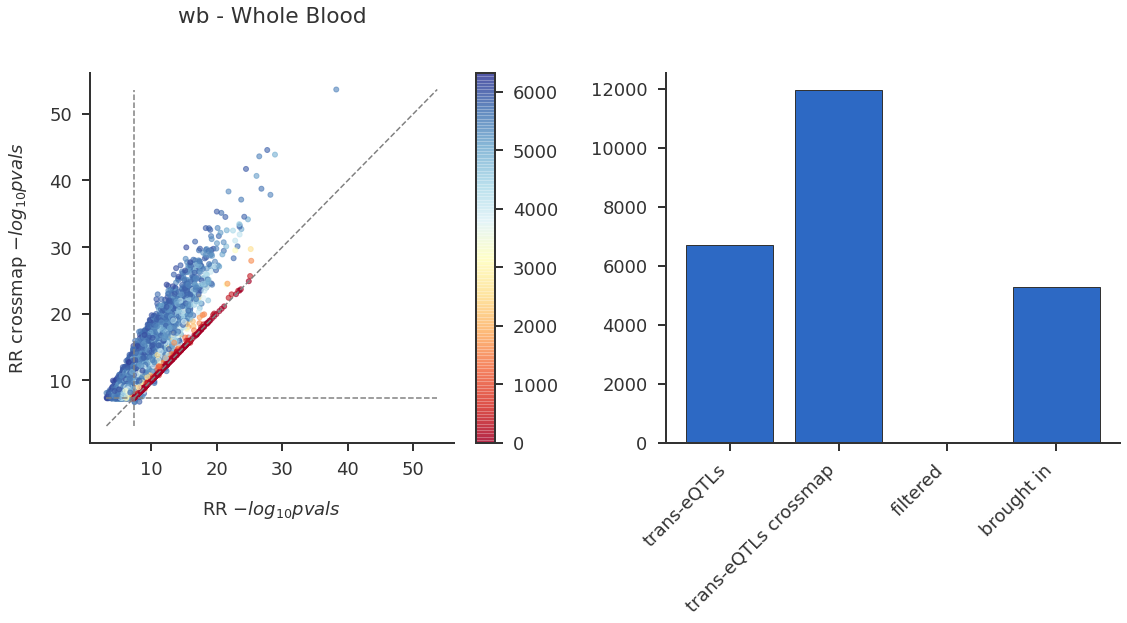

In [131]:
import matplotlib.pyplot as plt
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt')

global_cutoff = -np.log10(5e-8)
# for ts in tissues_set:
for ts in ['wb']:
    gx_file   = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
    snpids    = [x.rsid for x in teqtl_dict["sb"][ts]]
    snpids_cm = [x.rsid for x in teqtl_dict["cm"][ts]]
    
    both_sets = list(set(snpids + snpids_cm))
    
    logpvals    = pval_df_subset[ts][both_sets]
    logpvals_cm = pval_df_cm_subset[ts][both_sets]
    
    snpinfo_tissue = Snp2info(both_sets)
    ts_genes       = read_tissue_genes(gx_file, geneinfo_dict)
    
    #### Obtain cismasks and add crossmappable genes
    cismasklist = cismasking.get_cismasklist(snpinfo_tissue, ts_genes, None, window=1e6)
    cismaskcomp = cismasking.compress_cismasklist(cismasklist)
    crossmap_cismaskcomp = extend_cismask(ts_genes, cismaskcomp, cross_gene_dict)
    
    gene_diffs = np.zeros(len(snpinfo_tissue))
    for i in range(len(cismaskcomp)):
        gene_diffs[cismaskcomp[i].apply2] = len(crossmap_cismaskcomp[i].rmv_id) - len(cismaskcomp[i].rmv_id)
            
    cmap = plt.cm.get_cmap('RdYlBu')
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(121)
    p1 = ax1.scatter(logpvals, logpvals_cm, c=gene_diffs, cmap=cmap, alpha=0.6, s=25)
    ax1.set_xlabel("RR $-log_{10} pvals$")
    ax1.set_ylabel("RR crossmap $-log_{10} pvals$")
    if len(logpvals_cm) > 0 or len(logpvals) > 0:
        m = np.min([logpvals_cm, logpvals])
        M = np.max([logpvals_cm, logpvals])
    else:
        m = 0
        M = 0
    ax1.plot([m,M], [m,M], color='gray', linestyle='dashed')
    ax1.vlines(global_cutoff, m, M, color='gray', linestyle="dashed")
    ax1.hlines(global_cutoff, m, M, color='gray', linestyle="dashed")
    ax1.set_title(f"{ts} - {tissue_names[ts]}")
    fig.colorbar(p1, ax=ax1)
    
    ax2 = fig.add_subplot(122)
    notsig_after_cm = np.sum(logpvals_cm < global_cutoff)
    sig_after_cm = np.sum(logpvals < global_cutoff)
    bar_heights = [np.sum(logpvals > global_cutoff), np.sum(logpvals_cm > global_cutoff), notsig_after_cm, sig_after_cm]
    ax2.bar([1,2,3,4], bar_heights) #, tick_label=)
    ax2.set_xticks([1,2,3,4])
    ax2.set_xticklabels(labels=["trans-eQTLs", "trans-eQTLs crossmap", "filtered", "brought in"], rotation = 45, ha="right")

    plt.tight_layout()
    plt.savefig(f"plots/{ts}_crossmap_pvalues.jpg", dpi=300)
    plt.show()

# Export raw data to make plots elsewhere

In [81]:
import pandas as pd

for ts in ["wb"]: #tissues_set:
    gx_file   = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
    snpids    = [x.rsid for x in teqtl_dict["sb"][ts]]
    snpids_cm = [x.rsid for x in teqtl_dict["cm"][ts]]

    both_sets = list(set(snpids + snpids_cm))

    logpvals    = pval_df_subset[ts][both_sets]
    logpvals_cm = pval_df_cm_subset[ts][both_sets]

    snpinfo_tissue = Snp2info(both_sets)
    ts_genes       = read_tissue_genes(gx_file, geneinfo_dict)

    #### Obtain cismasks and add crossmappable genes
    cismasklist = cismasking.get_cismasklist(snpinfo_tissue, ts_genes, None, window=1e6)
    cismaskcomp = cismasking.compress_cismasklist(cismasklist)
    crossmap_cismaskcomp = extend_cismask(ts_genes, cismaskcomp, cross_gene_dict)

    gene_diffs = np.zeros(len(snpinfo_tissue))
    for i in range(len(cismaskcomp)):
        gene_diffs[cismaskcomp[i].apply2] = len(crossmap_cismaskcomp[i].rmv_id) - len(cismaskcomp[i].rmv_id)

    if np.all(logpvals.index == logpvals_cm.index):
        gdiffs_series = pd.Series(gene_diffs, index=logpvals.index)
        data = pd.concat((logpvals, logpvals_cm, gdiffs_series), axis=1)
        data.columns = ["logpvals", "logpvals_cm", "masked_genes"]
    data.to_csv(f"{ts}_teqtl_crossmap_pvals_maskgenes.txt", header=True, sep="\t", index=True)

# Get masked gene expressions


In [180]:
ts = optim_tissues[3]

gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
df = pd.read_csv(gx_file, header=0, index_col=0, sep="\t")

In [223]:
print(f"masked crossmap-genes: {len(crossmap_cismaskcomp[1].rmv_id)}")
print(f"masked cis-genes: {len(cismaskcomp[1].rmv_id)}")

4207
6


In [224]:
usegenes_cm = np.ones(df.shape[0], dtype=bool)
thismask_cm = crossmap_cismaskcomp[1]
if thismask_cm.rmv_id.shape[0] > 0: usegenes_cm[thismask_cm.rmv_id] = False      
df_cm = df[usegenes_cm]

usegenes = np.ones(df.shape[0], dtype=bool)
thismask = cismaskcomp[1]
if thismask.rmv_id.shape[0] > 0: usegenes[thismask.rmv_id] = False   
df_cis = df[usegenes]

print(df_cm.shape)
print(df_cis.shape)

(7788, 670)
(11989, 670)


## Mean and gx variance are almost the same after cross-mappability filter
## nothing to worry

In [225]:
print(np.mean(np.mean(df_cm.values, axis=1)))
print(np.mean(np.std(df_cm.values, axis=1)))

print(np.mean(np.mean(df_cis.values, axis=1)))
print(np.mean(np.std(df_cis.values, axis=1)))

3.3854090009459462e-18
1.0
1.9971612654891465e-18
1.0


# Load new crossmap results @ sb=0.01

In [ ]:
target_file    = "trans_eqtls.txt.ld_prune"
target_file2   = "trans_eqtls_ldpruned.txt"

## SHAPEIT 2 data
path_sb01    = "/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma01_knn30_cut5e-8/"
path_sb0006  = "/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma0006_knn30_cut5e-8/"
path_raw     = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2/raw/summary_5e-08/"
path_sb001   = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2_022021/raw/summary_5e-08/"


teqtls        = os.path.join(path_sb01, "{:s}/trans_eqtls_ldpruned.txt") 
teqtls_cm     = os.path.join(path_raw, "{:s}/tejaas", "permnull_sb0.1_knn30_crossmap", target_file)
alt_teqtls        = os.path.join(path_sb0006, "{:s}/trans_eqtls_ldpruned.txt") 
alt_teqtls_cm     = os.path.join(path_raw, "{:s}/tejaas", "permnull_sb0.006_knn30_crossmap", target_file)
alt_teqtls_cm001  = os.path.join(path_sb001, "{:s}/tejaas", "permnull_sb0.01_knn30_crossmap", target_file2)

teqtl_dict = collections.defaultdict(dict)
for ts in tshorts:
    if ts not in brain_tissues:
        if ts in optim_tissues:
            teqtl_dict["sb"][ts]    = tejaas(alt_teqtls.format(ts))
            teqtl_dict["cm"][ts]    = tejaas(alt_teqtls_cm.format(ts))
            teqtl_dict["cm001"][ts] = tejaas(alt_teqtls_cm001.format(ts))
        else:
            teqtl_dict["sb"][ts] = tejaas(teqtls.format(ts))
            teqtl_dict["cm"][ts] = tejaas(teqtls_cm.format(ts))

In [ ]:
unique_set = collections.defaultdict(set)
for ts in tshorts:
    if ts not in brain_tissues:
        if ts in optim_tissues:
            unique_set["sb"].update(set([x.rsid for x in teqtl_dict["sb"][ts]]))
            unique_set["cm"].update(set([x.rsid for x in teqtl_dict["cm"][ts]]))
            unique_set["cm001"].update(set([x.rsid for x in teqtl_dict["cm001"][ts]]))
            
configs = list(unique_set.keys())
for conf in configs:
    print(f"{conf}: {len(unique_set[conf])}")

In [32]:
for ts in optim_tissues:
    print(ts)
    print("\t",len(set([x.rsid for x in teqtl_dict["sb"][ts]])))
    print("\t",len(set([x.rsid for x in teqtl_dict["cm"][ts]])))
    print("\t",len(set([x.rsid for x in teqtl_dict["cm001"][ts]])))   

haa
	 64
	 236
	 12
pan
	 179
	 356
	 38
spl
	 1354
	 1666
	 474
wb
	 6269
	 11482
	 1580


In [36]:
import pandas as pd

pval_file = "/cbscratch/franco/from_saikat/gtex_v8_202003/all_variants_pvalues_tejaas_only4optims.txt"
pval_df   = pd.read_csv(pval_file, header=0, index_col=0, sep="\t")

cm0006_pval_file = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2/all_variants_pvalues_tejaas_only4optims_crossmap_sb0006.txt"
pval_df_cm0006   = pd.read_csv(cm0006_pval_file, header=0, index_col=0, sep="\t")

cm001_pval_file  = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2_022021/all_variants_pvalues_tejaas_only4optims_crossmap_sb001.txt"
pval_df_cm001    = pd.read_csv(cm001_pval_file, header=0, index_col=0, sep="\t")

/cbscratch/franco/tejaas/utils/mpl_stylesheet.py:26: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  r'\usepackage{microtype}',


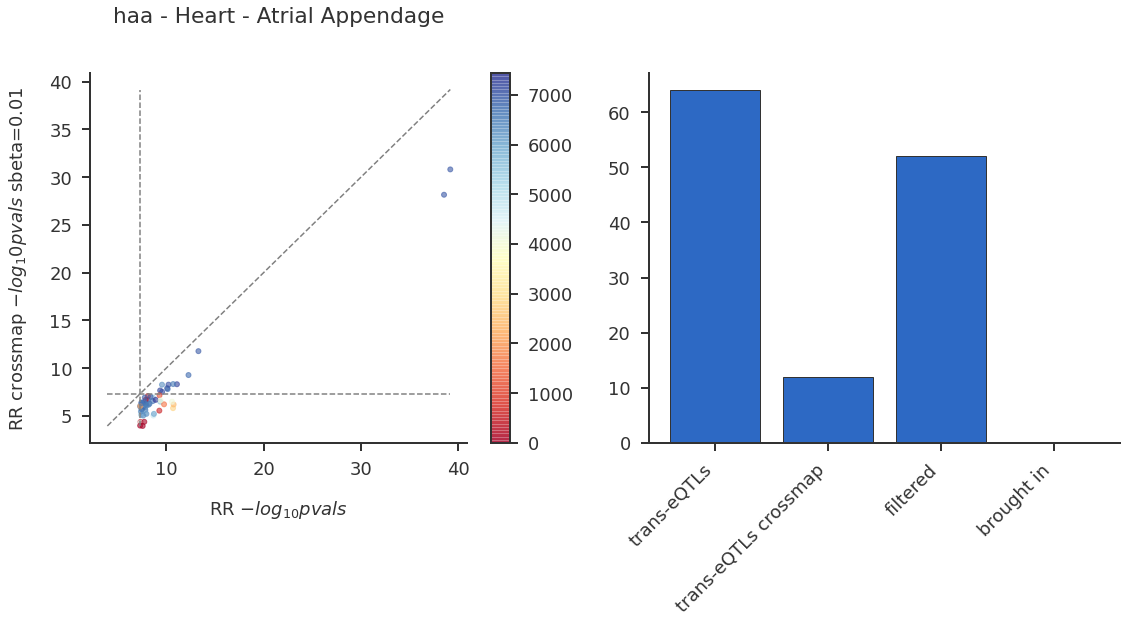

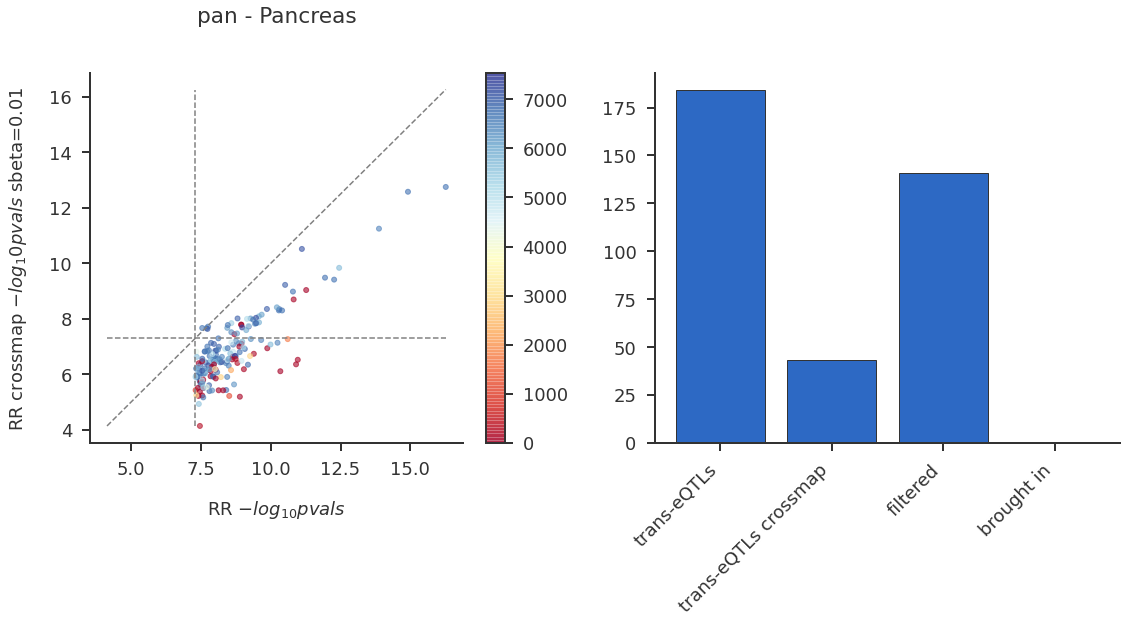

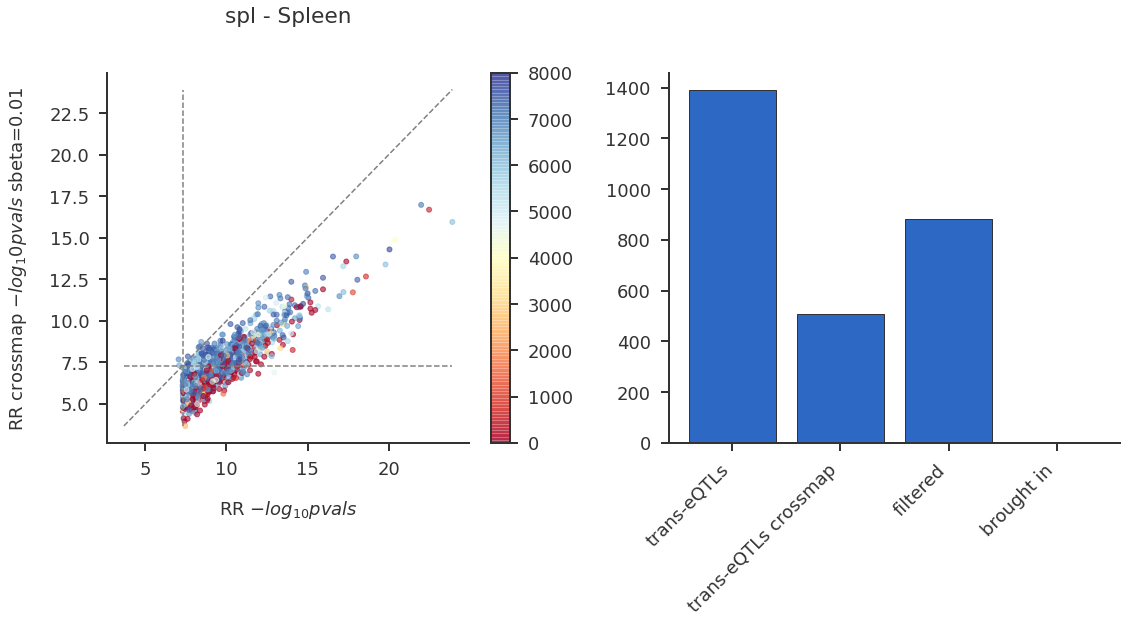

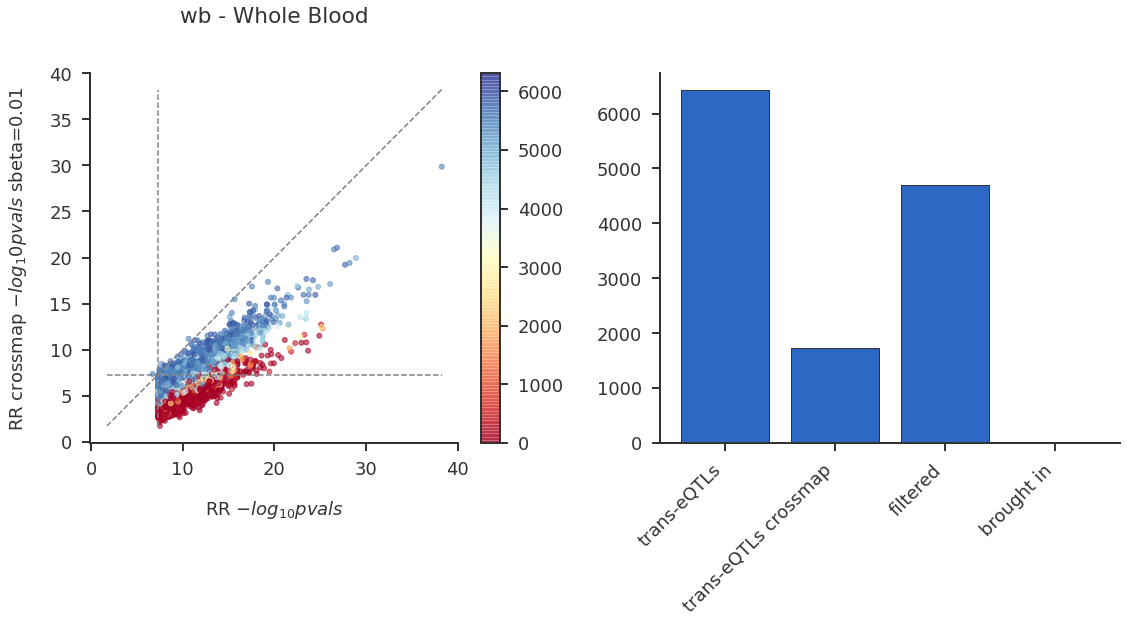

In [41]:
import matplotlib.pyplot as plt
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt')

global_cutoff = -np.log10(5e-8)
# for ts in tissues_set:

sbeta = 0.01
# sbeta = 0.006

for ts in optim_tissues:
    gx_file   = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
    snpids    = [x.rsid for x in teqtl_dict["sb"][ts]]
    if sbeta == 0.006:
        snpids_cm = [x.rsid for x in teqtl_dict["cm"][ts]]
    if sbeta == 0.01:
        snpids_cm = [x.rsid for x in teqtl_dict["cm001"][ts]]
    
    both_sets = list(set(snpids + snpids_cm))
    
    logpvals        = pval_df[ts][both_sets]
    if sbeta == 0.006:
        logpvals_cm = pval_df_cm0006[ts][both_sets]
    if sbeta == 0.01:
        logpvals_cm = pval_df_cm001[ts][both_sets]
    
    snpinfo_tissue = Snp2info(both_sets)
    ts_genes       = read_tissue_genes(gx_file, geneinfo_dict)
    
    #### Obtain cismasks and add crossmappable genes
    cismasklist = cismasking.get_cismasklist(snpinfo_tissue, ts_genes, None, window=1e6)
    cismaskcomp = cismasking.compress_cismasklist(cismasklist)
    crossmap_cismaskcomp = extend_cismask(ts_genes, cismaskcomp, cross_gene_dict)
    
    gene_diffs = np.zeros(len(snpinfo_tissue))
    for i in range(len(cismaskcomp)):
        gene_diffs[cismaskcomp[i].apply2] = len(crossmap_cismaskcomp[i].rmv_id) - len(cismaskcomp[i].rmv_id)
            
    cmap = plt.cm.get_cmap('RdYlBu')
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(121)
    p1 = ax1.scatter(logpvals, logpvals_cm, c=gene_diffs, cmap=cmap, alpha=0.6, s=25)
    ax1.set_xlabel("RR $-log_{10} pvals$")
    ax1.set_ylabel(f"RR crossmap $-log_{{10}} pvals$ sbeta={sbeta}")
    if len(logpvals_cm) > 0 or len(logpvals) > 0:
        m = np.min([logpvals_cm, logpvals])
        M = np.max([logpvals_cm, logpvals])
    else:
        m = 0
        M = 0
    ax1.plot([m,M], [m,M], color='gray', linestyle='dashed')
    ax1.vlines(global_cutoff, m, M, color='gray', linestyle="dashed")
    ax1.hlines(global_cutoff, m, M, color='gray', linestyle="dashed")
    ax1.set_title(f"{ts} - {tissue_names[ts]}")
    fig.colorbar(p1, ax=ax1)
    
    ax2 = fig.add_subplot(122)
    notsig_after_cm = np.sum(logpvals_cm < global_cutoff)
    sig_after_cm = np.sum(logpvals < global_cutoff)
    bar_heights = [np.sum(logpvals > global_cutoff), np.sum(logpvals_cm > global_cutoff), notsig_after_cm, sig_after_cm]
    ax2.bar([1,2,3,4], bar_heights) #, tick_label=)
    ax2.set_xticks([1,2,3,4])
    ax2.set_xticklabels(labels=["trans-eQTLs", "trans-eQTLs crossmap", "filtered", "brought in"], rotation = 45, ha="right")

    plt.tight_layout()
    plt.savefig(f"plots/{ts}_crossmap_pvalues_sbeta{sbeta}.jpg", dpi=300)
    plt.show()